In [1]:
!pip install -U git+https://github.com/d2l-ai/d2l-en.git@master

  Cloning https://github.com/d2l-ai/d2l-en.git (to revision master) to /tmp/pip-req-build-w1h4fxui
  Running command git clone -q https://github.com/d2l-ai/d2l-en.git /tmp/pip-req-build-w1h4fxui
  Created wheel for d2l: filename=d2l-0.15.1-cp36-none-any.whl size=72690 sha256=01ebeaf6771e2a46f6e1534448c24e6e6cba206c8f0d8b80fb2b93bf616931da
  Stored in directory: /tmp/pip-ephem-wheel-cache-h4ptwd8v/wheels/0f/41/8f/72ece70ede8a0e37eec72c03087eb4604925ba212b804f8cad
Successfully built d2l


In [2]:
from d2l import torch as d2l
import torch
from torch import nn
import os
import pandas as pd

In [3]:
#@save
d2l.DATA_HUB['ml-100k'] = (
    'http://files.grouplens.org/datasets/movielens/ml-100k.zip',
    'cd4dcac4241c8a4ad7badc7ca635da8a69dddb83')

#@save
def read_data_ml100k():
    data_dir = d2l.download_extract('ml-100k')
    names = ['user_id', 'item_id', 'rating', 'timestamp']
    data = pd.read_csv(os.path.join(data_dir, 'u.data'), '\t', names=names,
                       engine='python')
    num_users = data.user_id.unique().shape[0]
    num_items = data.item_id.unique().shape[0]
    return data, num_users, num_items

In [4]:
data, num_users, num_items = read_data_ml100k()
sparsity = 1 - len(data) / (num_users * num_items)
print(f'number of users: {num_users}, number of items: {num_items}')
print(f'matrix sparsity: {sparsity:f}')
print(data.head(5))

number of users: 943, number of items: 1682
matrix sparsity: 0.936953
   user_id  item_id  rating  timestamp
0      196      242       3  881250949
1      186      302       3  891717742
2       22      377       1  878887116
3      244       51       2  880606923
4      166      346       1  886397596


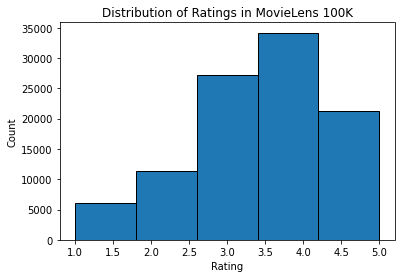

In [5]:
d2l.plt.hist(data['rating'], bins=5, ec='black')
d2l.plt.xlabel('Rating')
d2l.plt.ylabel('Count')
d2l.plt.title('Distribution of Ratings in MovieLens 100K')
d2l.plt.show()

In [6]:
#@save
def split_data_ml100k(data, num_users, num_items,
                      split_mode='random', test_ratio=0.1):
    """Split the dataset in random mode or seq-aware mode."""
    if split_mode == 'seq-aware':
        train_items, test_items, train_list = {}, {}, []
        for line in data.itertuples():
            u, i, rating, time = line[1], line[2], line[3], line[4]
            train_items.setdefault(u, []).append((u, i, rating, time))
            if u not in test_items or test_items[u][-1] < time:
                test_items[u] = (i, rating, time)
        for u in range(1, num_users + 1):
            train_list.extend(sorted(train_items[u], key=lambda k: k[3]))
        test_data = [(key, *value) for key, value in test_items.items()]
        train_data = [item for item in train_list if item not in test_data]
        train_data = pd.DataFrame(train_data)
        test_data = pd.DataFrame(test_data)
    else:
        mask = [True if x == 1 else False for x in np.random.uniform(
            0, 1, (len(data))) < 1 - test_ratio]
        neg_mask = [not x for x in mask]
        train_data, test_data = data[mask], data[neg_mask]
    return train_data, test_data

https://discuss.pytorch.org/t/generating-random-tensors-according-to-the-uniform-distribution-pytorch/53030

toch.rand returns a tensor samples uniformly in [0, 1). Scaling it as shown in your example should work.

In [7]:
#@save
def split_data_ml100k(data, num_users, num_items,
                      split_mode='random', test_ratio=0.1):
    """Split the dataset in random mode or seq-aware mode."""
    if split_mode == 'seq-aware':
        train_items, test_items, train_list = {}, {}, []
        for line in data.itertuples():
            u, i, rating, time = line[1], line[2], line[3], line[4]
            train_items.setdefault(u, []).append((u, i, rating, time))
            if u not in test_items or test_items[u][-1] < time:
                test_items[u] = (i, rating, time)
        for u in range(1, num_users + 1):
            train_list.extend(sorted(train_items[u], key=lambda k: k[3]))
        test_data = [(key, *value) for key, value in test_items.items()]
        train_data = [item for item in train_list if item not in test_data]
        train_data = pd.DataFrame(train_data)
        test_data = pd.DataFrame(test_data)
    else:
        mask = [True if x == 1 else False for x in (len(data))*torch.rand()< 1 - test_ratio]
        neg_mask = [not x for x in mask]
        train_data, test_data = data[mask], data[neg_mask]
    return train_data, test_data

#@save
def load_data_ml100k(data, num_users, num_items, feedback='explicit'):
    users, items, scores = [], [], []
    inter = torch.zeros((num_items, num_users)) if feedback == 'explicit' else {}
    for line in data.itertuples():
        user_index, item_index = int(line[1] - 1), int(line[2] - 1)
        score = int(line[3]) if feedback == 'explicit' else 1
        users.append(user_index)
        items.append(item_index)
        scores.append(score)
        if feedback == 'implicit':
            inter.setdefault(user_index, []).append(item_index)
        else:
            inter[item_index, user_index] = score
    return users, items, scores, inter

In [8]:
from torch.utils import data

In [9]:
#@save
def split_and_load_ml100k(split_mode='seq-aware', feedback='explicit',
                          test_ratio=0.1, batch_size=256):
    data, num_users, num_items = read_data_ml100k()
    train_data, test_data = split_data_ml100k(
        data, num_users, num_items, split_mode, test_ratio)
    train_u, train_i, train_r, _ = load_data_ml100k(
        train_data, num_users, num_items, feedback)
    test_u, test_i, test_r, _ = load_data_ml100k(
        test_data, num_users, num_items, feedback)
    train_set = data.TensorDataset(
        torch.tensor(train_u), torch.tensor(train_i), torch.tensor(train_r))
    test_set = data.ArrayDataset(
        torch.tensor(test_u), torch.tensor(test_i), torch.tensor(test_r))
    train_iter = data.DataLoader(
        train_set, shuffle=True, 
        batch_size=batch_size)
    test_iter = data.DataLoader(
        test_set, batch_size=batch_size)
    return num_users, num_items, train_iter, test_iter

last_batch='rollover'

class MF(nn.Block):
    def __init__(self, num_factors, num_users, num_items, **kwargs):
        super(MF, self).__init__(**kwargs)
        self.P = nn.Embedding(input_dim=num_users, output_dim=num_factors)
        self.Q = nn.Embedding(input_dim=num_items, output_dim=num_factors)
        self.user_bias = nn.Embedding(num_users, 1)
        self.item_bias = nn.Embedding(num_items, 1)

    def forward(self, user_id, item_id):
        P_u = self.P(user_id)
        Q_i = self.Q(item_id)
        b_u = self.user_bias(user_id)
        b_i = self.item_bias(item_id)
        outputs = (P_u * Q_i).sum(axis=1) + np.squeeze(b_u) + np.squeeze(b_i)
        return outputs.flatten()

https://pytorch.org/docs/stable/generated/torch.squeeze.html

In [10]:
class MF(nn.Block):
    def __init__(self, num_factors, num_users, num_items, **kwargs):
        super(MF, self).__init__(**kwargs)
        self.P = nn.Embedding(num_embeddings=num_users, embedding_dim=num_factors)
        self.Q = nn.Embedding(num_embeddings=num_items, embedding_dim=num_factors)
        self.user_bias = nn.Embedding(num_users, 1)
        self.item_bias = nn.Embedding(num_items, 1)

    def forward(self, user_id, item_id):
        P_u = self.P(user_id)
        Q_i = self.Q(item_id)
        b_u = self.user_bias(user_id)
        b_i = self.item_bias(item_id)
        outputs = (P_u * Q_i).sum(axis=1) + torch.squeeze(b_u) + torch.squeeze(b_i)
        return outputs.flatten()

AttributeError: ignored

In [ ]:
class MF(nn.Module):
    def __init__(self, num_factors, num_users, num_items, **kwargs):
        super(MF, self).__init__(**kwargs)
        self.P = nn.Embedding(num_embeddings=num_users, embedding_dim=num_factors)
        self.Q = nn.Embedding(num_embeddings=num_items, embedding_dim=num_factors)
        self.user_bias = nn.Embedding(num_users, 1)
        self.item_bias = nn.Embedding(num_items, 1)

    def forward(self, user_id, item_id):
        P_u = self.P(user_id)
        Q_i = self.Q(item_id)
        b_u = self.user_bias(user_id)
        b_i = self.item_bias(item_id)
        outputs = (P_u * Q_i).sum(axis=1) + torch.squeeze(b_u) + torch.squeeze(b_i)
        return outputs.flatten()

https://pytorch-lightning.readthedocs.io/en/0.8.3/api/pytorch_lightning.metrics.regression.html

def evaluator(net, test_iter, devices):
    rmse = mx.metric.RMSE()  # Get the RMSE
    rmse_list = []
    for idx, (users, items, ratings) in enumerate(test_iter):
        u = gluon.utils.split_and_load(users, devices, even_split=False)
        i = gluon.utils.split_and_load(items, devices, even_split=False)
        r_ui = gluon.utils.split_and_load(ratings, devices, even_split=False)
        r_hat = [net(u, i) for u, i in zip(u, i)]
        rmse.update(labels=r_ui, preds=r_hat)
        rmse_list.append(rmse.get()[1])
    return float(np.mean(np.array(rmse_list)))

In [ ]:
def evaluator(net, test_iter, devices):
    rmse = pytorch_lightning.metrics.RMSE()  # Get the RMSE
    rmse_list = []
    for idx, (users, items, ratings) in enumerate(test_iter):
        u = gluon.utils.split_and_load(users, devices, even_split=False)
        i = gluon.utils.split_and_load(items, devices, even_split=False)
        r_ui = gluon.utils.split_and_load(ratings, devices, even_split=False)
        r_hat = [net(u, i) for u, i in zip(u, i)]
        rmse.update(labels=r_ui, preds=r_hat)
        rmse_list.append(rmse.get()[1])
    return float(np.mean(np.array(rmse_list)))

https://discuss.pytorch.org/t/l2-loss-in-pytorch/13684
l2loss
MSELoss:https://pytorch.org/docs/stable/generated/torch.nn.MSELoss.html

In [ ]:
#@save
def train_recsys_rating(net, train_iter, test_iter, loss, trainer, num_epochs,
                        devices=d2l.try_all_gpus(), evaluator=None,
                        **kwargs):
    timer = d2l.Timer()
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0, 2],
                            legend=['train loss', 'test RMSE'])
    for epoch in range(num_epochs):
        metric, l = d2l.Accumulator(3), 0.
        for i, values in enumerate(train_iter):
            timer.start()
            input_data = []
            values = values if isinstance(values, list) else [values]
            for v in values:
                input_data.append(gluon.utils.split_and_load(v, devices))
            train_feat = input_data[0:-1] if len(values) > 1 else input_data
            train_label = input_data[-1]
            with autograd.record():
                preds = [net(*t) for t in zip(*train_feat)]
                ls = [loss(p, s) for p, s in zip(preds, train_label)]
            [l.backward() for l in ls]
            l += sum([l.asnumpy() for l in ls]).mean() / len(devices)
            trainer.step(values[0].shape[0])
            metric.add(l, values[0].shape[0], values[0].size)
            timer.stop()
        if len(kwargs) > 0:  # It will be used in section AutoRec
            test_rmse = evaluator(net, test_iter, kwargs['inter_mat'],
                                  devices)
        else:
            test_rmse = evaluator(net, test_iter, devices)
        train_l = l / (i + 1)
        animator.add(epoch + 1, (train_l, test_rmse))
    print(f'train loss {metric[0] / metric[1]:.3f}, '
          f'test RMSE {test_rmse:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec '
          f'on {str(devices)}')

In [ ]:
devices = d2l.try_all_gpus()
num_users, num_items, train_iter, test_iter = d2l.split_and_load_ml100k(
    test_ratio=0.1, batch_size=512)
net = MF(30, num_users, num_items)

lr, num_epochs, wd = 0.002, 20, 1e-5
loss = nn.MSELoss(reduction = 'sum')
trainer = torch.optim.Adam(net.parameters(), lr=lr, weight_decay=wd)
TODO:train_recsys_rating(net, train_iter, test_iter, loss, trainer, num_epochs,
                    devices, evaluator)

In [ ]:
scores = net(torch.tensor([20], dtype='int', device=devices[0]),
             torch.tensor([30], dtype='int', device=devices[0]))
scores